# **Решающее дерево**


**Решающее дерево** - алгоритм, строящий иерархическую структуру условий для принятия решений.

**Основные компоненты**:
- **Узел**: точка разделения данных по условию
- **Лист**: конечное предсказание
- **Критерий разделения**:
  - Для классификации: энтропия, индекс Джини
  - Для регрессии: MSE, MAE


# Пример дерева из sklearn
```python
from sklearn.tree import plot_tree
plt.figure(figsize=(15,10))
plot_tree(DecisionTreeRegressor(max_depth=2).fit(X2_train, y2_train), filled=True)
plt.show()
```

# **Градиентный бустинг**

**Градиентный бустинг** — это метод машинного обучения, который строит ансамбль слабых моделей (обычно решающих деревьев), объединяя их последовательно, чтобы каждая следующая модель корректировала ошибки предыдущих. Основная цель — минимизировать функцию потерь за счет движения в направлении, обратном градиенту ошибки (антиградиенту).



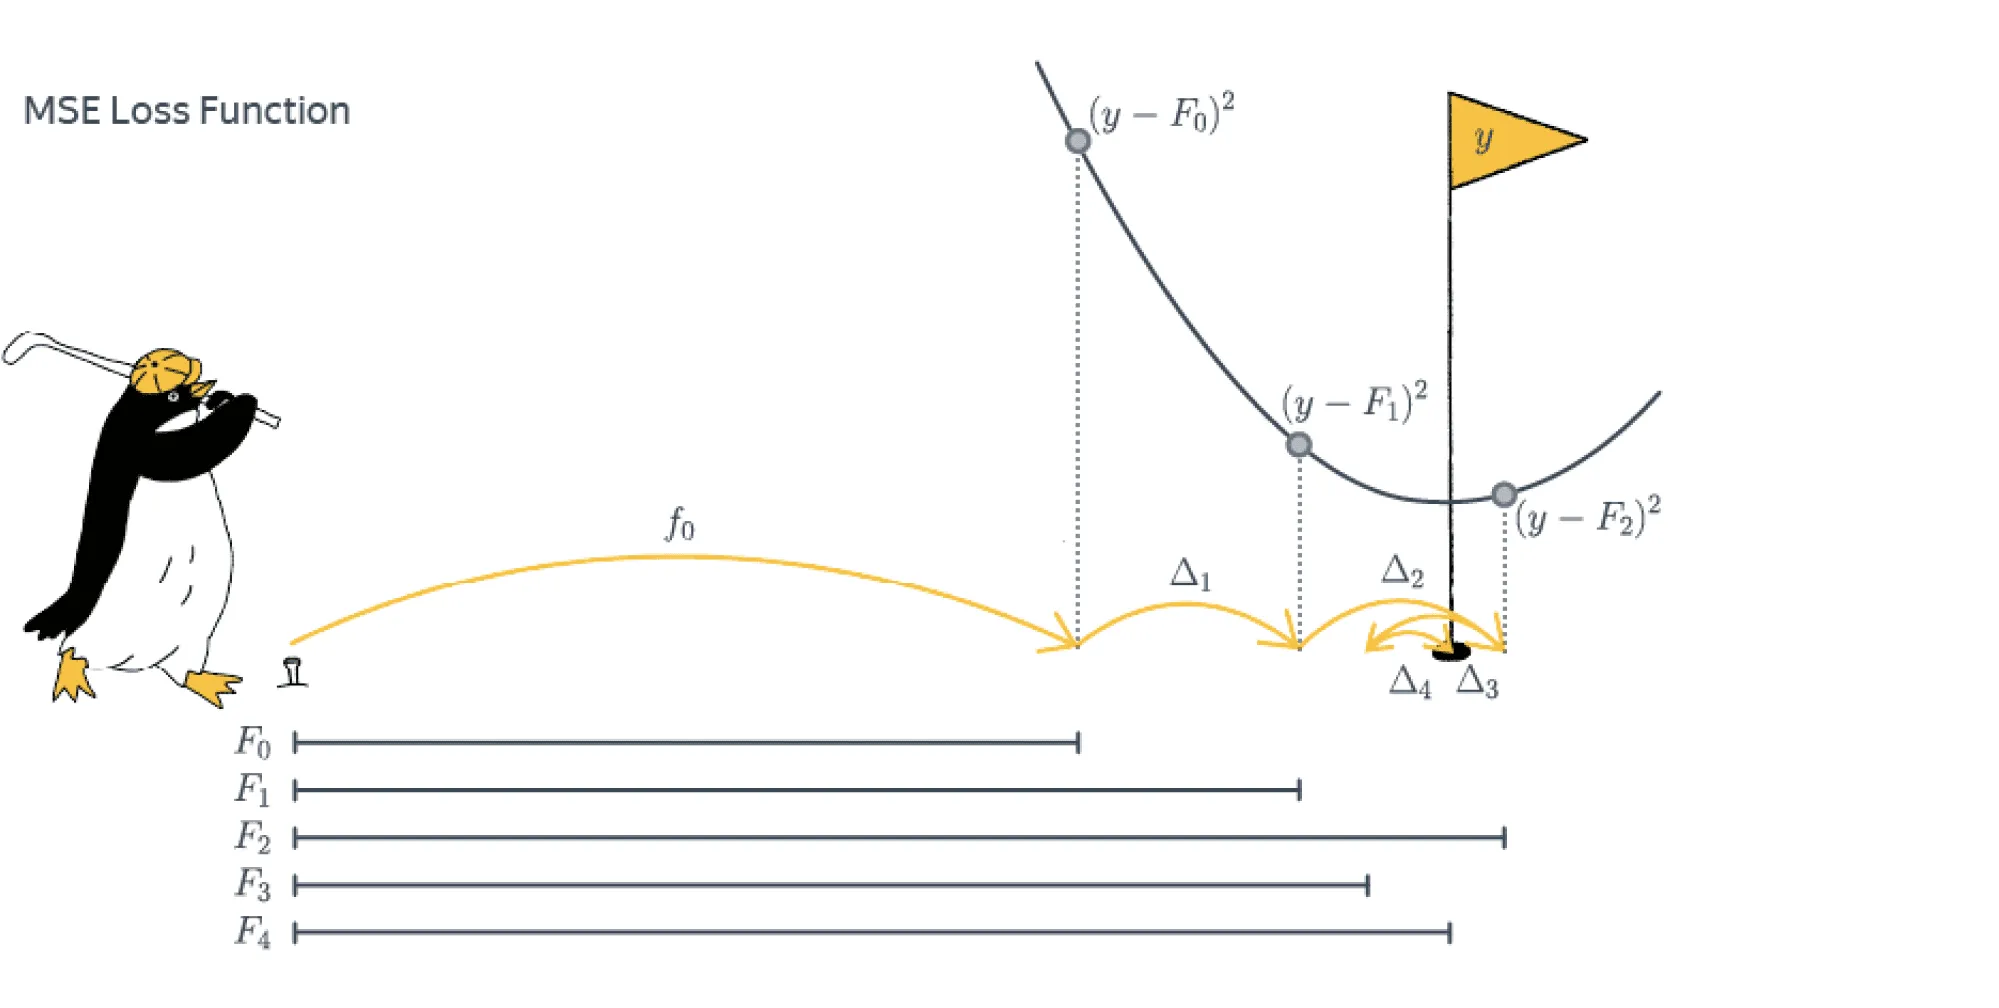
[Источник](https://explained.ai/gradient-boosting/L2-loss.html)

Начальное предсказание - константа:
$$ F_0(x) = \arg\min_{\gamma} \sum_{i=1}^n L(y_i, \gamma) $$

**Пример для регрессии**:  
$$ F_0(x) = \text{среднее}(y) $$

#### 2. Последовательное добавление моделей
Для каждой итерации $m = 1, 2, ..., M$:

**Шаг 1. Вычисление антиградиента (остатков)**  
$$ r_{im} = -\left[\frac{\partial L(y_i, F(x_i))}{\partial F(x_i)}\right]_{F=F_{m-1}} $$

*Для MSE (регрессия)*:  
$$ r_{im} = y_i - F_{m-1}(x_i) $$

**Шаг 2. Обучение нового дерева**  
- Обучаем решающее дерево $h_m(x)$ на данных $(x_i, r_{im})$  
- Цель: предсказывать остатки текущей модели  

**Шаг 3. Обновление предсказаний**  
$$ F_m(x) = F_{m-1}(x) + \eta \cdot h_m(x) $$  
Где $\eta$ - темп обучения (обычно 0.01-0.3)

#### 3. Итоговая модель
$$ F_M(x) = F_0(x) + \eta \sum_{m=1}^M h_m(x) $$



---

### Визуализация процесса в коде
```python
# Простая реализация для регрессии
import numpy as np
from sklearn.tree import DecisionTreeRegressor

class SimpleGradientBoosting:
    def __init__(self, n_estimators=100, learning_rate=0.1, max_depth=3):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.max_depth = max_depth
        self.trees = []
        
    def fit(self, X, y):
        # Инициализация
        self.F0 = np.mean(y)
        F = np.full_like(y, self.F0, dtype=np.float32)
        
        for _ in range(self.n_estimators):
            # 1. Вычисление остатков
            residuals = y - F
            
            # 2. Обучение дерева на остатках
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(X, residuals)
            
            # 3. Обновление предсказаний
            F += self.learning_rate * tree.predict(X)
            self.trees.append(tree)



# **Отличия от случайного леса**:
- Последовательное vs параллельное обучение
- Коррекция ошибок vs усреднение независимых моделей
- Выше риск переобучения, но лучше качество при правильной настройке




# **Сравнение библиотек**
| Характеристика      | XGBoost               | LightGBM            | CatBoost            | Sklearn             |
|---------------------|-----------------------|---------------------|---------------------|---------------------|
| Стратегия роста     | Level-wise (симметричные) | Leaf-wise (несимметричные) | Симметричные уровни | Level-wise          |
| Обработка категорий | One-hot encoding      | Оптимизированные split | Встроенная обработка | Требуется препроцессинг |
| Скорость обучения   | Средняя               | Высокая             | Средняя             | Низкая              |
| Регуляризация       | L1, L2, сложная       | L1, L2              | L2, упорядоченное бустинг | Базовые           |
| Особенности         | Точность, гибкость   | Эффективность с большими данными | Защита от переобучения, категории | Простота использования |

# **Особенности построения деревьев в библиотеках бустинга**

**1. LightGBM (Leaf-Wise Growth)**

▸ Стратегия роста:

На каждом шаге выбирает лист с максимальным приростом информации

Разрастается асимметрично (глубина поддеревьев может сильно отличаться)

Пример: левая ветвь — глубина 2, правая — глубина 15

▸ Контроль переобучения:

Ограничение num_leaves (макс. количество листьев)

Дополнительно: max_depth (обычно выше, чем у других библиотек)

▸ Плюсы:

Быстрая адаптация к паттернам данных

Эффективен на больших датасетах

▸ Минусы:

Требует тонкой настройки регуляризации

Риск переобучения при малом количестве данных



**2. XGBoost (Level-Wise Growth)**

▸ Стратегия роста:

Строит дерево послойно (уровень за уровнем)

Стремится к симметричной структуре

Максимальная глубина (max_depth) — основной критерий остановки

▸ Архитектура:

Формирует полные бинарные деревья (даже если разделение неоптимально)

Автоматический баланс между ветвями

▸ Плюсы:

Естественная регуляризация через симметрию

Стабильность на небольших данных

▸ Минусы:

Менее гибкий для сложных паттернов

Вычислительная нагрузка на глубоких уровнях

**3. CatBoost (Symmetric Trees)**

▸ Стратегия роста:

Все узлы на одном уровне используют одинаковые условия разделения

Создает полные бинарные деревья даже для пустых ветвей

▸ Инженерные особенности:

Векторизация операций через битовые маски

Оптимизация для батч-обработки

▸ Плюсы:

Автоматическая регуляризация за счет симметрии

3-5x ускорение инференса vs другие библиотеки

Устойчивость к переобучению "из коробки"

▸ Минусы:

Менее гибкий рост (фиксированная структура)

Больший расход памяти

# **Практика**

**Процесс настройки:**

Начните с базовых параметров

1. Оптимизируйте глубину деревьев

2. Подберите темп обучения

3. Добавьте регуляризацию

4. Настройте субдискретизацию

5. Используйте кросс-валидацию

# **Загрузка необходимых библиотек**


In [79]:
!pip install catboost

zsh:1: command not found: pip


In [80]:
import pandas as pd
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
import time

# **Загрузка данных**


In [81]:
# Загрузка Glass Classification Dataset
glass_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/glass/glass.data"
glass_columns = ['Id', 'RI', 'Na', 'Mg', 'Al', 'Si', 'K', 'Ca', 'Ba', 'Fe', 'Type']
glass_df = pd.read_csv(glass_url, header=None, names=glass_columns).drop('Id', axis=1)

# Подготовка данных для классификации
X1 = glass_df.drop('Type', axis=1)
y1 = glass_df['Type']

# Кодирование меток для классификации
le = LabelEncoder()
y1 = pd.Series(le.fit_transform(y1))

# Разделение на train/test
X1_train, X1_test, y1_train, y1_test = train_test_split(
    X1, y1,
    test_size=0.25,
    random_state=42,
    stratify=y1
)

print("Glass dataset:")
print(f"Train: {X1_train.shape}, Test: {X1_test.shape}")
print(f"Classes: {len(le.classes_)}")

Glass dataset:
Train: (160, 9), Test: (54, 9)
Classes: 6


In [82]:
# Загрузка Diabetes Dataset (регрессия)
diabetes = load_diabetes()
X2 = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
y2 = pd.Series(diabetes.target)

# Разделение на train/test
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2, y2,
    test_size=0.25,
    random_state=42
)

print("\nDiabetes dataset:")
print(f"Train: {X2_train.shape}, Test: {X2_test.shape}")
print(f"Target range: [{y2.min()}, {y2.max()}]")


Diabetes dataset:
Train: (331, 10), Test: (111, 10)
Target range: [25.0, 346.0]


# **Функции обучения**

In [83]:
# Классификация на датасете Glass
def train_classifiers(X_train, X_test, y_train, y_test):
    models = {
        'XGBoost': xgb.XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1),
        'LightGBM': lgb.LGBMClassifier(n_estimators=100, max_depth=3, learning_rate=0.1),
        'CatBoost': CatBoostClassifier(iterations=100, depth=3, learning_rate=0.1, verbose=False),
        'Sklearn': GradientBoostingClassifier(n_estimators=100, max_depth=3, learning_rate=0.1)
    }

    results = {}
    for name, model in models.items():
        start = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start
        preds = model.predict(X_test)
        acc = accuracy_score(y_test, preds)
        results[name] = {'accuracy': acc, 'time': train_time}

    return results

In [84]:
# Регрессия на датасете Diabetes
def train_regressors(X_train, X_test, y_train, y_test):
    models = {
        'XGBoost': xgb.XGBRegressor(n_estimators=100, max_depth=3, learning_rate=0.1),
        'LightGBM': lgb.LGBMRegressor(n_estimators=100, max_depth=3, learning_rate=0.1),
        'CatBoost': CatBoostRegressor(iterations=100, depth=3, learning_rate=0.1, verbose=False),
        'Sklearn': GradientBoostingRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
    }

    results = {}
    for name, model in models.items():
        start = time.time()
        model.fit(X_train, y_train)
        train_time = time.time() - start
        preds = model.predict(X_test)
        mse = mean_squared_error(y_test, preds)
        results[name] = {'MSE': mse, 'time': train_time}

    return results

In [85]:
class_results = train_classifiers(X1_train, X1_test, y1_train, y1_test)
regress_results = train_regressors(X2_train, X2_test, y2_train, y2_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000702 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 334
[LightGBM] [Info] Number of data points in the train set: 160, number of used features: 9
[LightGBM] [Info] Start training from score -1.123930
[LightGBM] [Info] Start training from score -1.032123
[LightGBM] [Info] Start training from score -2.510224
[LightGBM] [Info] Start training from score -2.772589
[LightGBM] [Info] Start training from score -3.129264
[LightGBM] [Info] Start training from score -2.030651
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

# **Визуализация**

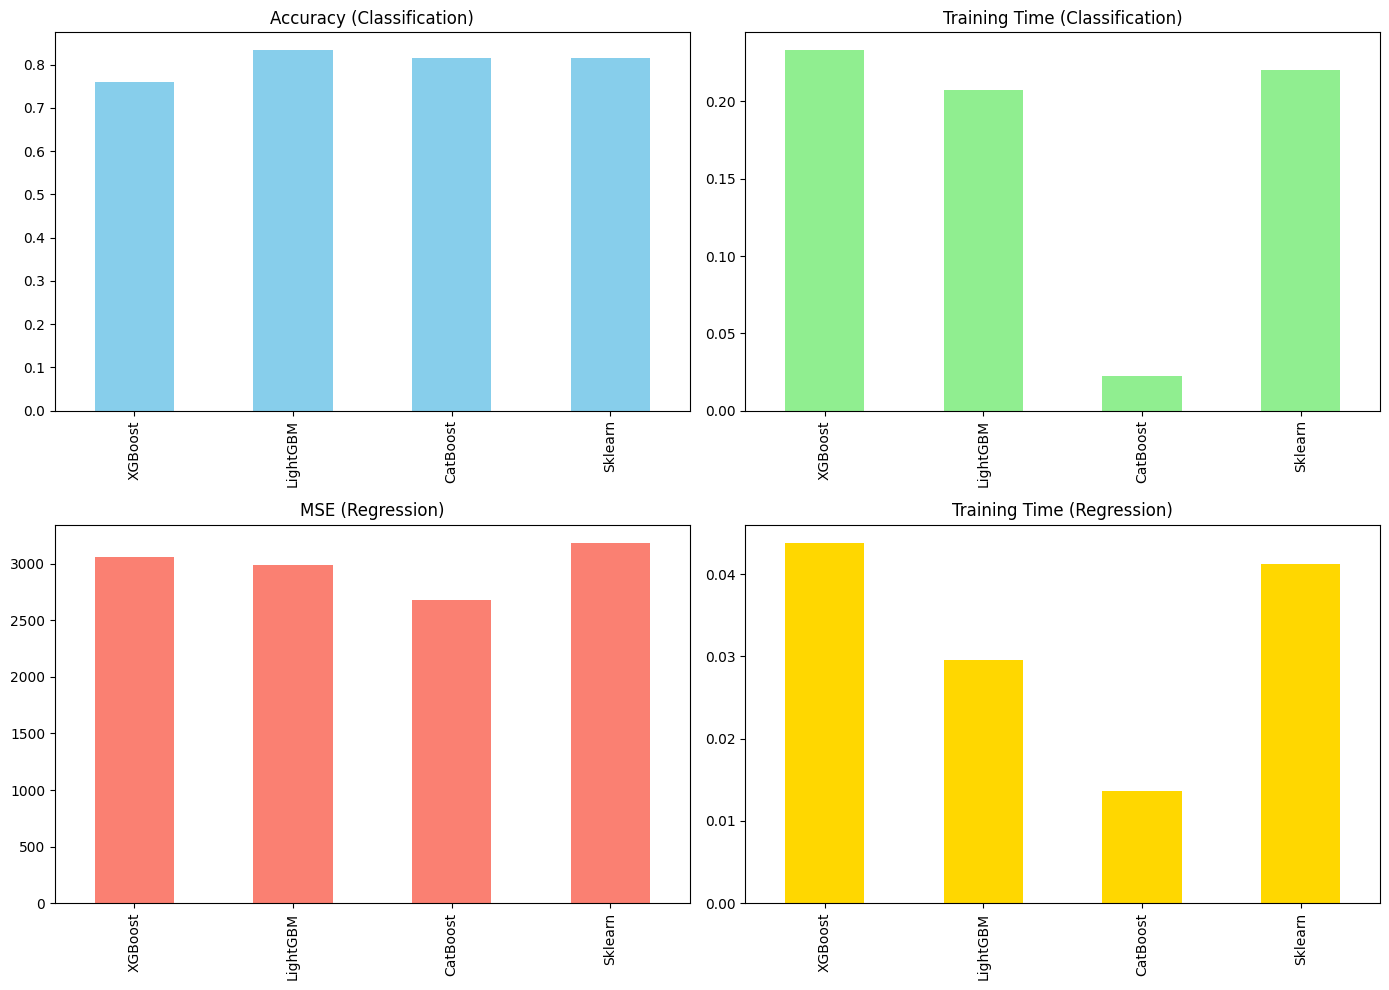

In [86]:
import matplotlib.pyplot as plt
import pandas as pd

# Создаем DataFrame с результатами
df_class = pd.DataFrame(class_results).T
df_regress = pd.DataFrame(regress_results).T

# Графики точности и времени обучения
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Классификация
df_class['accuracy'].plot(kind='bar', ax=axes[0,0], title='Accuracy (Classification)', color='skyblue')
df_class['time'].plot(kind='bar', ax=axes[0,1], title='Training Time (Classification)', color='lightgreen')

# Регрессия
df_regress['MSE'].plot(kind='bar', ax=axes[1,0], title='MSE (Regression)', color='salmon')
df_regress['time'].plot(kind='bar', ax=axes[1,1], title='Training Time (Regression)', color='gold')

plt.tight_layout()
plt.show()

In [87]:
from xgboost import plot_tree
import matplotlib.pyplot as plt

<Figure size 2000x1000 with 0 Axes>

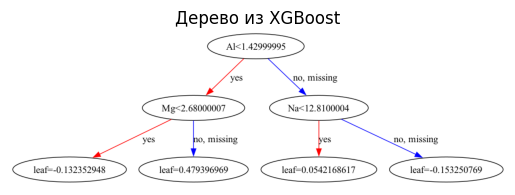

In [88]:
# Визуализация дерева из XGBoost
model_xgb = xgb.XGBClassifier(n_estimators=1, max_depth=2)
model_xgb.fit(X1_train, y1_train)

plt.figure(figsize=(20,10))
plot_tree(model_xgb, tree_idx=0)
plt.title("Дерево из XGBoost")
plt.show()

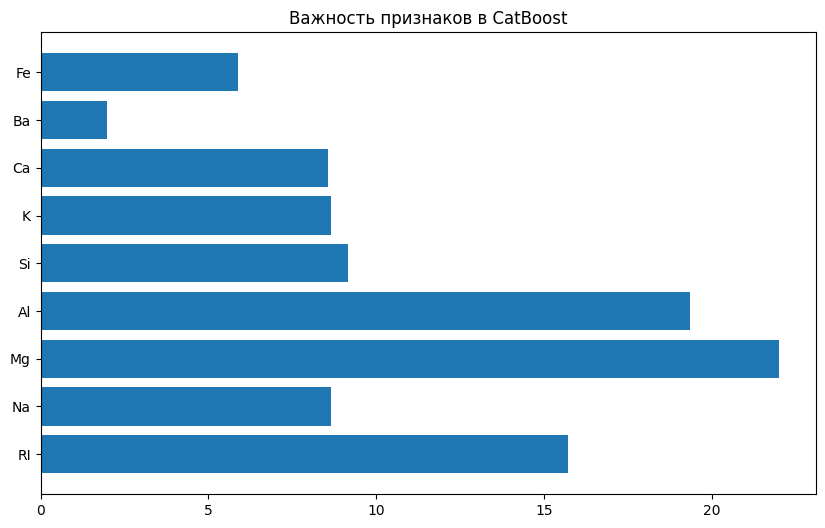

In [89]:
# Визуализация важности признаков для CatBoost
model_cat = CatBoostClassifier(iterations=100, verbose=False)
model_cat.fit(X1_train, y1_train)

plt.figure(figsize=(10,6))
plt.barh(X1.columns, model_cat.get_feature_importance())
plt.title("Важность признаков в CatBoost")
plt.show()

# **Практические советы**

1. **XGBoost**:
   - Когда нужен максимальный контроль над параметрами
   - Для соревнований по ML (Kaggle)
   - При работе с гетерогенными данными

2. **LightGBM**:
   - Для больших датасетов (>100k строк)
   - Когда важна скорость обучения
   - Нет доступа к хорошему железу

3. **CatBoost**:
   - При наличии категориальных признаков
   - Для защиты от переобучения
   - Когда нужна автоматическая обработка данных

4. **Sklearn**:
   - Для быстрого прототипирования
   - При интеграции в sklearn-пайплайны
   - Для образовательных целей

### Советы по настройке гиперпараметров
- Начинайте с малого количества деревьев (100-500)
- Оптимальная глубина деревьев: 3-5
- Learning rate: 0.01-0.3 (меньше rate → больше деревьев)
- Регуляризация: увеличивайте при переобучении
- Используйте early stopping для автоматического выбора числа деревьев

In [90]:
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split

In [91]:
train_pool = Pool(X1_train, y1_train)
val_pool = Pool(X1_test, y1_test)

In [95]:
model = CatBoostClassifier(
    iterations=1000,
    depth=5,
    learning_rate=0.05,
    early_stopping_rounds=2, #50
    verbose=100
)

In [96]:
model.fit(train_pool, eval_set=val_pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1.7479201	test: 1.7484425	best: 1.7484425 (0)	total: 1.72ms	remaining: 1.72s
100:	learn: 0.5634703	test: 0.7268878	best: 0.7268878 (100)	total: 52.8ms	remaining: 470ms
200:	learn: 0.3100104	test: 0.5733321	best: 0.5733321 (200)	total: 88.4ms	remaining: 351ms
Stopped by overfitting detector  (2 iterations wait)

bestTest = 0.5283906326
bestIteration = 259

Shrink model to first 260 iterations.


In [97]:
# Вывод истории обучения
plt.figure(figsize=(10,6))
plt.plot(model.get_eval_results()['validation']['Accuracy'], label='Validation')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')
plt.title('Learning Curve with Early Stopping')
plt.legend()
plt.show()

AttributeError: 'CatBoostClassifier' object has no attribute 'get_eval_results'

<Figure size 1000x600 with 0 Axes>

# **Домашнее задание**

Необходимо решить [контест на kaggle по предскзаанию стоимости жилья](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques)

Необходимо предоставить полный нотубук (хорошо оформеленный, с комментариями для себя и для меня!). Для начала необходимо провести EDA, так же зарегистрируйтесь на гитхаб